# Gaussianization Flows

In [1]:
#@title Install Packages
# %%capture
try:
    import sys, os
    from pyprojroot import here

    # spyder up to find the root
    root = here(project_files=[".here"])

    # append to path
    sys.path.append(str(here()))
except ModuleNotFoundError:
    %%capture
    import os
    os.system("pip install objax chex")
    os.system("pip install git+https://github.com/IPL-UV/rbig_jax.git#egg=rbig_jax")

In [2]:
# jax packages
import jax
import jax.numpy as np
from jax.config import config
# import chex
config.update("jax_enable_x64", False)

import numpy as onp
from functools import partial

# library functions
from rbig_jax.data import get_classic
from rbig_jax.plots import plot_joint, plot_joint_prob, plot_info_loss
import objax
import chex
from rbig_jax.transforms.mixture import MixtureGaussianCDF
from rbig_jax.transforms.logit import Logit
from rbig_jax.transforms.inversecdf import InverseGaussCDF
from rbig_jax.transforms.linear import HouseHolder
from rbig_jax.transforms.base import CompositeTransform


# logging
import tqdm
import wandb

# plot methods
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Demo Data

<Figure size 432x288 with 0 Axes>

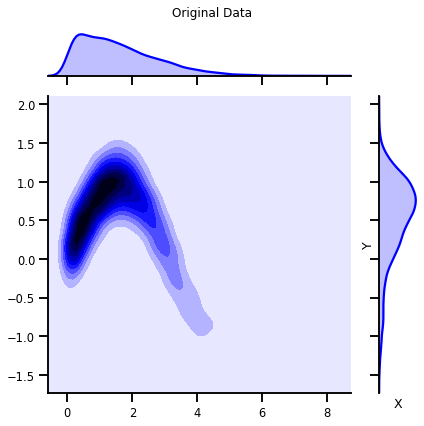

In [3]:
# %%wandb
# get data
n_samples = 2_000
n_features = 2
data = get_classic(10_000)

# plot data
plot_joint(data, "blue", "Original Data", kind='kde', logger=False)

### Model

In [4]:
n_samples = 2_000
n_features = 2

# generate data
data = get_classic(n_samples)

#### Layer 1 - Mixture Gaussian CDF Transform

In [5]:
%%time
# model components
n_components = 10
n_reflections = 10

# initialize model
layer_1 = MixtureGaussianCDF(n_features=n_features, n_components=n_components)


# forward transformation
x1, logabsdet = layer_1(np.array(data))

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


CPU times: user 2.74 s, sys: 41.6 ms, total: 2.79 s
Wall time: 2.76 s


<Figure size 432x288 with 0 Axes>

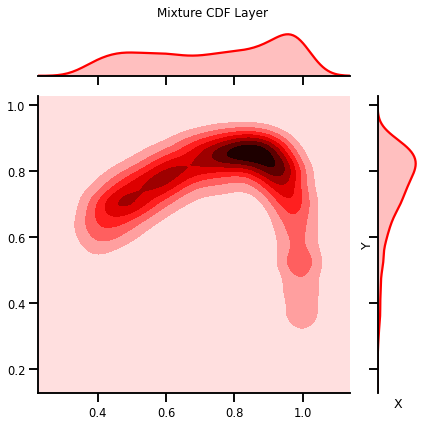

In [6]:
# plot data
plot_joint(x1, "red", "Mixture CDF Layer", kind='kde', logger=False)

#### Layer III - Logit Transformation

In [7]:
# initialize model
model_layer2 = InverseGaussCDF()

# forward transformation
x2, logabsdet = model_layer2(x1)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


<Figure size 432x288 with 0 Axes>

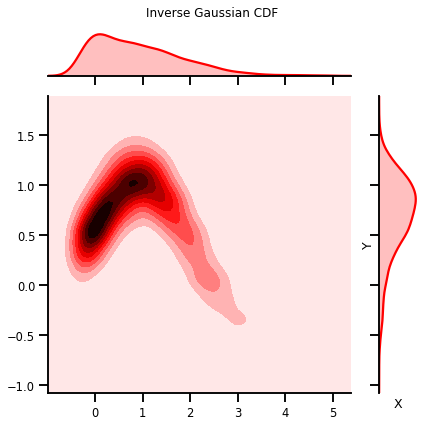

In [8]:
plot_joint(x2, "red", "Inverse Gaussian CDF", kind='kde', logger=False)

#### Layer 3 - HouseHolder Transformation

In [9]:
# layer hyperparameters
learn = 10
n_reflections = 10
generator = objax.random.Generator(123)

# initialize model
model_layer3 = HouseHolder(n_features=n_features, n_reflections=n_reflections, generator=generator)

# forward transformation
z, logabsdet = model_layer2(x2)

/home/emmanuel/.conda/envs/jax_py38/lib/python3.8/site-packages/jax/lax/lax.py:6190: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


<Figure size 432x288 with 0 Axes>

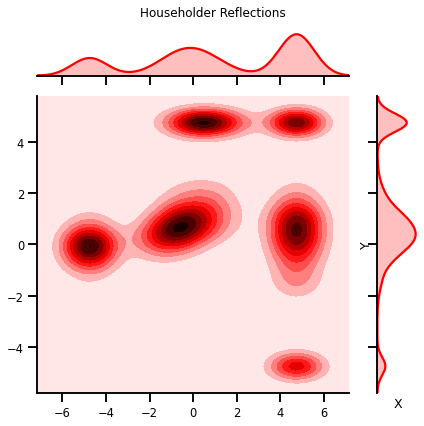

In [10]:
plot_joint(z, "red", "Householder Reflections", kind='kde', logger=False)

## Gaussianization Flows

In [11]:
from rbig_jax.models.gaussflow import GaussianizationFlow

In [41]:


# model hyperparameters
n_components = 20
n_reflections = 2
generator = objax.random.Generator(123)
learn_temperature = False

# initialize model
gf_model = CompositeTransform([
    # Layer I
    MixtureGaussianCDF(n_features=n_features, n_components=n_components),
    Logit(learn_temperature=learn_temperature),
    HouseHolder(n_features=n_features, n_reflections=n_reflections, generator=generator),
    # Layer II
    MixtureGaussianCDF(n_features=n_features, n_components=n_components),
    Logit(learn_temperature=learn_temperature),
    HouseHolder(n_features=n_features, n_reflections=n_reflections, generator=generator),
    # Layer III
    MixtureGaussianCDF(n_features=n_features, n_components=n_components),
    Logit(learn_temperature=learn_temperature),
    HouseHolder(n_features=n_features, n_reflections=n_reflections, generator=generator),
    # Layer IV
    MixtureGaussianCDF(n_features=n_features, n_components=n_components),
    Logit(learn_temperature=learn_temperature),
    HouseHolder(n_features=n_features, n_reflections=n_reflections, generator=generator),
])


<Figure size 432x288 with 0 Axes>

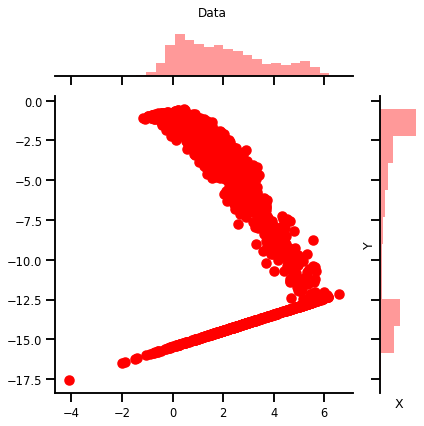

In [44]:
x_transform, _ = gf_model(np.array(data))

plot_joint(x_transform, "red", "Data", kind='scatter', logger=False)

#### Loss Function

In [45]:
# vectorized the model to allow for batches
# model_vectorized = objax.Vectorize(model, vc=model.vars())

# model_jitted = objax.Jit(model, vc=model.vars())


@objax.Function.with_vars(gf_model.vars())
def nll_loss(x):
    # forward run of model
    z, log_abs_det = gf_model(x)


    # log probability
    log_prob = jax.scipy.stats.norm.logpdf(z)

    # negative log-likelihood
    nll = log_prob.sum(axis=1) + log_abs_det
    return - nll.mean()

In [46]:
nll_loss(data)

DeviceArray(62.316353, dtype=float32)

##### Optimizer

In [47]:
# define the optimizer
opt = objax.optimizer.Adam(gf_model.vars())

# get grad values
gv = objax.GradValues(nll_loss, gf_model.vars())
lr = 0.01
epochs = 500
batch_size = 128

@objax.Function.with_vars(gf_model.vars() + opt.vars())
def train_op(x):
    g, v = gv(x)  # returns gradients, loss
    opt(lr, g)
    return v

# This line is optional: it is compiling the code to make it faster.
train_op = objax.Jit(train_op)


#### Testing

In [48]:
import itertools
from jax import device_put
import tqdm
from jax import random


# initialize parameters
key = random.PRNGKey(123)
itercount = itertools.count()
permute_rng, rng = random.split(key)

train_data = np.array(data)

losses = list()

pbar = tqdm.trange(epochs)

with pbar:
    for i in pbar:

        # batch processing
        permute_rng, rng = random.split(rng)

        # randomly shuffle the data
        train_data = random.permutation(permute_rng, train_data)

        # Train
        avg_loss = []

        for batch_index in range(0, n_samples, batch_size):
            # compute loss
            loss = float(train_op( train_data[batch_index:batch_index+batch_size])[0])
            # append batch
            avg_loss.append(loss)
        # average loss
        batch_loss = np.mean(np.stack(avg_loss))

        # Log losses
        losses.append(batch_loss)
        pbar.set_postfix({"loss": f"{batch_loss:.4f}"})

100%|██████████| 500/500 [01:06<00:00,  7.50it/s, loss=1.4264] 


#### Losses

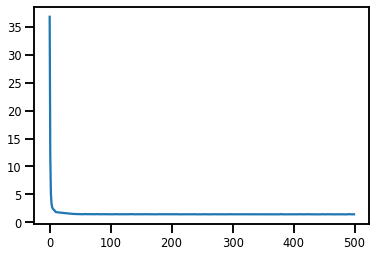

In [49]:
plt.plot(losses)

#### Forward Transformation

In [50]:
# forward transformation
z, logabsdet = gf_model(np.array(data))

<Figure size 432x288 with 0 Axes>

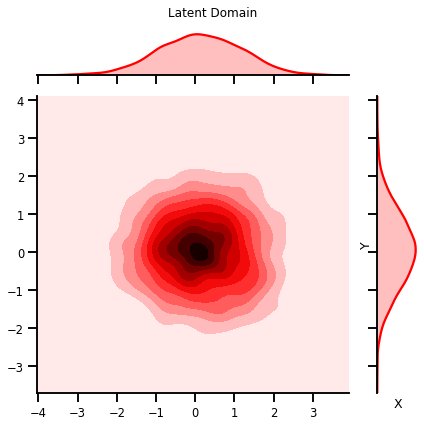

In [51]:
plot_joint(onp.array(z), "red", "Latent Domain", kind='kde', logger=False)

### Application I - Generating Samples

In [52]:
# generate samples in the latent domain
n_gen_samples = 2_000
z_samples = objax.random.normal(shape=(n_gen_samples, n_features), generator=generator)

# inverse transformation
x_samples = gf_model.inverse(z_samples)

<Figure size 432x288 with 0 Axes>

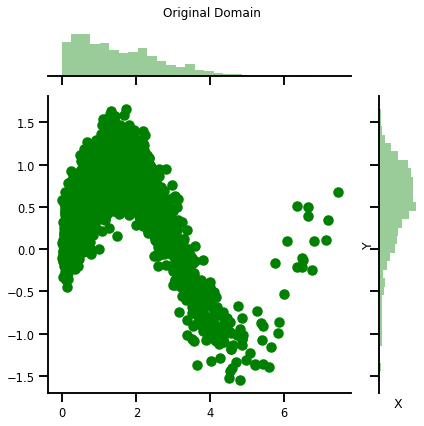

In [53]:
plot_joint(onp.array(x_samples), "green", "Original Domain", kind='scatter', logger=False)

### Probability Density Estimation

In [54]:
# forward transformation
z, logabsdet = gf_model(np.array(data))

In [55]:
# log probability
z_prob = jax.scipy.stats.norm.logpdf(z).sum(axis=1)

# change of variables
log_prob = z_prob + logabsdet

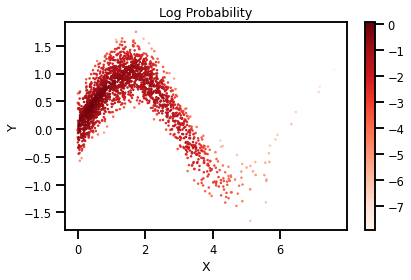

In [56]:
cmap = "Reds"
probs = np.array(log_prob)
# probs = np.clip(probs, 0.0, 1.0)
title = "Log Probability"

fig, ax = plt.subplots()
h = ax.scatter(data[:, 0], data[:, 1], s=1, c=log_prob,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

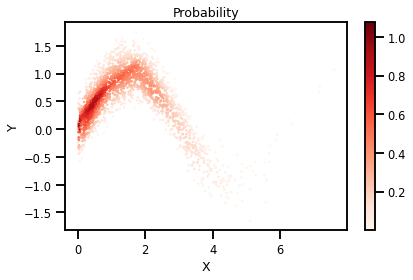

In [57]:
cmap = "Reds"
probs = np.exp(np.array(log_prob))
# probs = np.clip(probs, 0.0, 1.0)
title = "Probability"

fig, ax = plt.subplots()
h = ax.scatter(data[:, 0], data[:, 1], s=1, c=probs,  cmap=cmap)
plt.xlabel("X")
plt.ylabel("Y")
plt.colorbar(h)
ax.set_title(title)
plt.tight_layout()

### Demo of Transform between Layers

<Figure size 432x288 with 0 Axes>

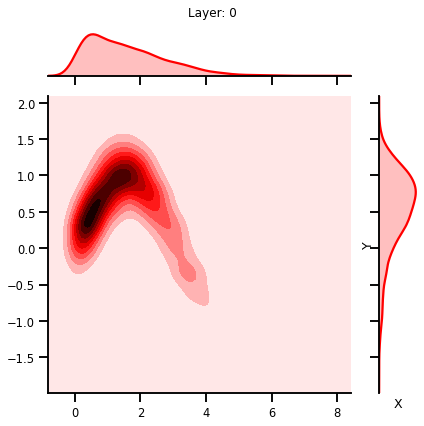

<Figure size 432x288 with 0 Axes>

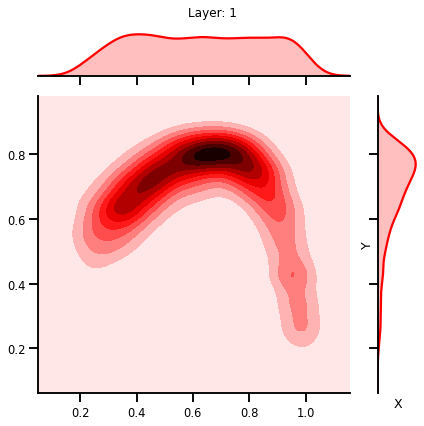

<Figure size 432x288 with 0 Axes>

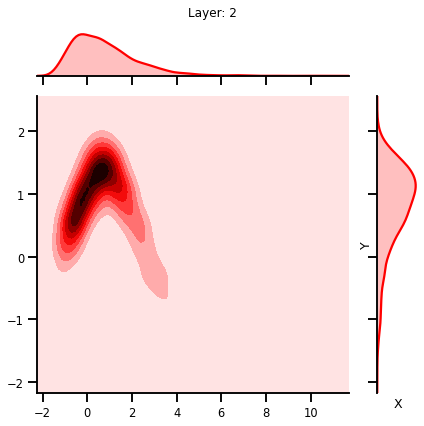

<Figure size 432x288 with 0 Axes>

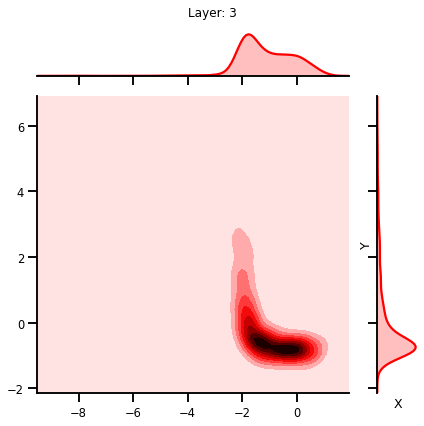

<Figure size 432x288 with 0 Axes>

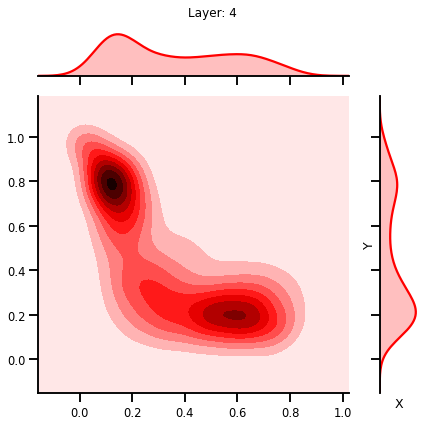

<Figure size 432x288 with 0 Axes>

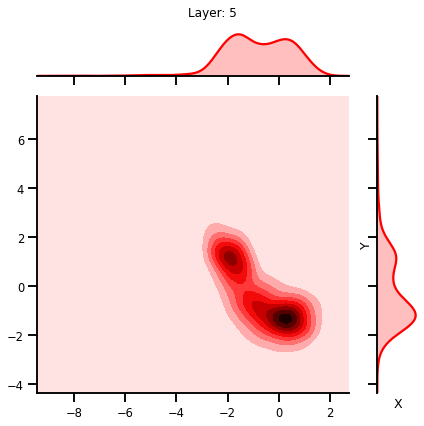

<Figure size 432x288 with 0 Axes>

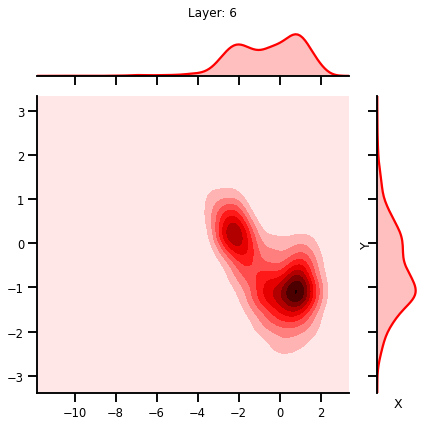

<Figure size 432x288 with 0 Axes>

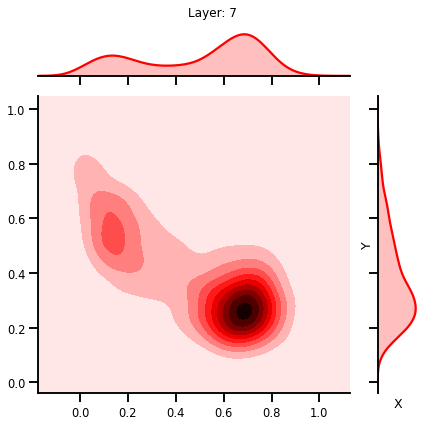

<Figure size 432x288 with 0 Axes>

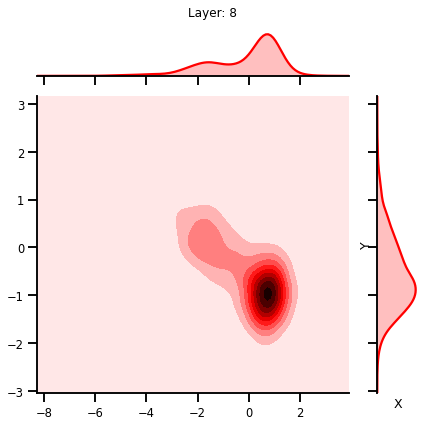

<Figure size 432x288 with 0 Axes>

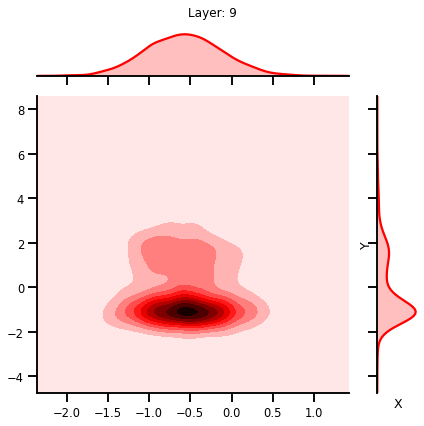

<Figure size 432x288 with 0 Axes>

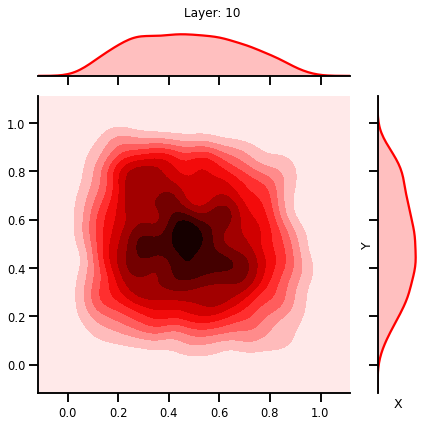

<Figure size 432x288 with 0 Axes>

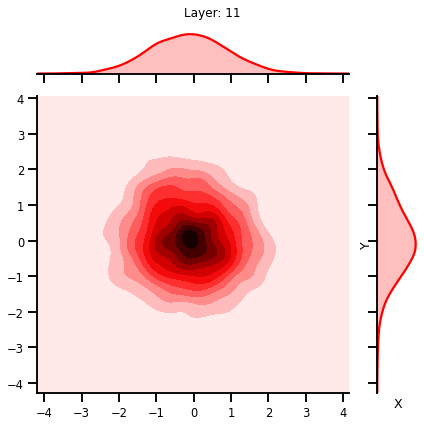

<Figure size 432x288 with 0 Axes>

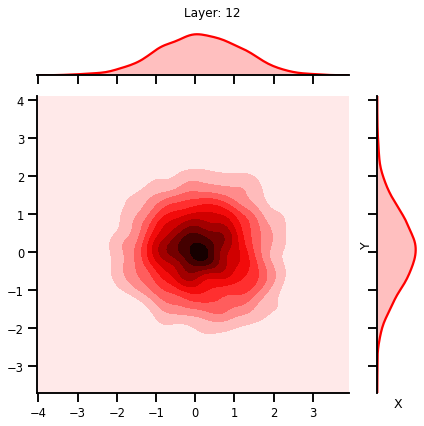

In [58]:
outputs = data
plot_joint(onp.array(outputs), "red", f"Layer: 0", kind='kde', logger=False)
for ilayer, itransform in enumerate(gf_model._transforms):
    outputs = itransform.transform(outputs)
    plot_joint(onp.array(outputs), "red", f"Layer: {ilayer+1}", kind='kde', logger=False)